In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split

In [ ]:
dataset_train = datasets.MNIST('.', download=True, train=True)
dataset_test = datasets.MNIST('.', download=True, train=False)

In [ ]:
X_train, X_test = dataset_train.data, dataset_test.data
y_train, y_test = dataset_train.targets, dataset_test.targets

print(f'Train dataset:\nX_train shape is {X_train.shape}; target shape is {y_train.shape}', end='\n\n')
print(f'Test dataset:\nX_test shape is {X_test.shape}; target shape is {y_test.shape}')

Train dataset:
X_train shape is torch.Size([60000, 28, 28]); target shape is torch.Size([60000])

Test dataset:
X_test shape is torch.Size([10000, 28, 28]); target shape is torch.Size([10000])


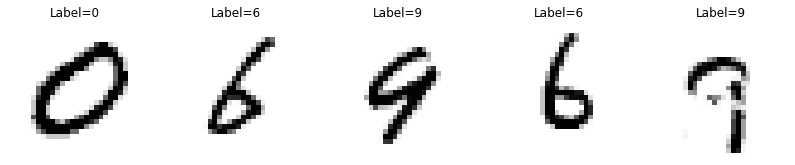

In [ ]:
# посмотрим на картинки
n_sample = 5
samples = np.random.choice(X_train.size(0), size=n_sample)

fig, ax = plt.subplots(nrows=1, ncols=n_sample, figsize=(14, 8))
for i in range(n_sample):
    ax[i].imshow(X_train[samples[i]], cmap='Greys')
    ax[i].set_title(f'Label={y_train[samples[i]]}')
    ax[i].axis('off')

In [ ]:
BATCH_SIZE=128

X_train, X_test = X_train.float(), X_test.float()

# DataLoader для полносвязаной сети
TrainDataset = TensorDataset(X_train.view(X_train.size(0), -1), y_train)
TestDataset = TensorDataset(X_test.view(X_test.size(0), -1), y_test)

DataLoaderFCN = {
    name: DataLoader(dataset=dataset,
                     batch_size=BATCH_SIZE,
                     shuffle=True,
                     drop_last=True) for name, dataset in zip(['train', 'validation'], [TrainDataset, TestDataset])
}

# DataLoader для свёрточной сети
TrainDatasetConv = TensorDataset(X_train.unsqueeze(1), y_train)
TestDatasetConv = TensorDataset(X_test.unsqueeze(1), y_test)

DataLoaderCNN = {
    name: DataLoader(dataset=dataset,
                     batch_size=BATCH_SIZE,
                     shuffle=True,
                     drop_last=True) for name, dataset in zip(['train', 'validation'], [TrainDatasetConv, TestDatasetConv])
}

# Полносвязная нейронная сеть

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.1):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.do1 = nn.Dropout(dropout_p)
        self.act1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.do2 = nn.Dropout(dropout_p)
        self.act2 = nn.ReLU()
        self.linear3 = nn.Linear(hidden_dim // 2, output_dim)

    def forward(self, X):
        X = self.act1(self.do1(self.linear1(X)))
        X = self.act2(self.do2(self.linear2(X)))
        X = self.linear3(X)

        return X

In [ ]:
# hyperparams
inp_dim = 28 * 28
hidden_dim = 128
out_dim = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
n_epochs = 50

In [ ]:
model = LinearModel(inp_dim, hidden_dim, out_dim, dropout_p=0.4).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

In [ ]:
loss_history = {'train': [], 'validation': []}
accuracy_history = {'train': [], 'validation': []}

for epoch in range(n_epochs):
    for stage in ['train', 'validation']:
        model.train() if stage == 'train' else model.eval()
        loss_step = []
        accuracy_step = torch.Tensor().to(device)

        for x_batch, y_batch in DataLoaderFCN[stage]:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            predict= model(x_batch)
            loss = loss_func(predict, y_batch)

            if stage == 'train':
                loss.backward()
                optim.step()
                optim.zero_grad()

            loss_step.append(loss.item())
            accuracy = (predict.argmax(dim=1) == y_batch).float()
            accuracy_step = torch.hstack((accuracy_step, accuracy))

        # calculate loss
        loss_step = torch.tensor(loss_step).data.mean()
        loss_history[stage].append(loss_step)

        # calculate accuracy
        accuracy_history[stage].append(accuracy_step.mean().item())
    
    if epoch % 5 == 0:
        print(f'Epoch №{epoch} complete')
    
    # save every epoch
    #torch.save(model.state_dict(), f'./chkpt_{epoch}.pth')

Epoch №0 complete
Epoch №5 complete
Epoch №10 complete
Epoch №15 complete
Epoch №20 complete
Epoch №25 complete
Epoch №30 complete
Epoch №35 complete
Epoch №40 complete
Epoch №45 complete


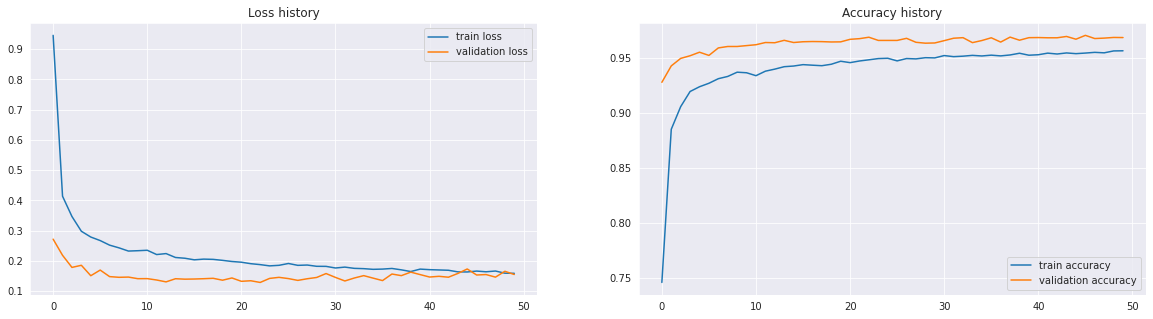

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

axs[0].plot(loss_history['train'], label='train loss')
axs[0].plot(loss_history['validation'], label='validation loss')
axs[0].set_title('Loss history')
axs[0].legend()

axs[1].plot(accuracy_history['train'], label='train accuracy')
axs[1].plot(accuracy_history['validation'], label='validation accuracy')
axs[1].set_title('Accuracy history')
axs[1].legend();

Полносвязная нейронная сеть достигла точности ~96%. Превышение точности на валидационных данных по сравнению обучающими связано с наличием слоёв dropout, которые сильно уменьшают скорость достижения переобучения модели (запоминающей способности).

# Сверточная нейронная сеть

In [ ]:
class ConvModel(nn.Module):
    def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, padding=2, stride=2)
        self.bn1 = nn.BatchNorm2d(hidden_ch)
        self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(hidden_ch)
        self.conv3 = nn.Conv2d(hidden_ch, 5, kernel_size=3, padding=1, stride=1)
        self.classifier = nn.Linear(5 * 14 * 14, output_dim)
        self.do1 = nn.Dropout(dropout_p)
        self.do2 = nn.Dropout(dropout_p)

        self.act1 = nn.Sigmoid()
        self.act2 = nn.Sigmoid()
        self.act3 = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.do1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.do2(x)

        x = self.conv3(x)
        x = self.act3(x)

        x = self.classifier(x.view(x.size(0), -1)) # вытягиваем в вектор B x 5*14*14

        return x

In [ ]:
# hyperparams
input_ch = 1
hidden_ch = 32
out_dim = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
n_epochs = 50

In [ ]:
model_conv = ConvModel(input_ch, hidden_ch, out_dim).to(device)
optim = torch.optim.Adam(model_conv.parameters())
loss_func = nn.CrossEntropyLoss()

In [ ]:
loss_history = {'train': [], 'validation': []}
accuracy_history = {'train': [], 'validation': []}

for epoch in range(n_epochs):
    for stage in ['train', 'validation']:
        model_conv.train() if stage == 'train' else model_conv.eval()
        loss_step = []
        accuracy_step = torch.Tensor().to(device)

        for x_batch, y_batch in DataLoaderCNN[stage]:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            predict= model_conv(x_batch)
            loss = loss_func(predict, y_batch)

            if stage == 'train':
                loss.backward()
                optim.step()
                optim.zero_grad()

            loss_step.append(loss.item())
            accuracy = (predict.argmax(dim=1) == y_batch).float()
            accuracy_step = torch.hstack((accuracy_step, accuracy))

        # calculate loss
        loss_step = torch.tensor(loss_step).data.mean()
        loss_history[stage].append(loss_step)

        # calculate accuracy
        accuracy_history[stage].append(accuracy_step.mean().item())
    
    if epoch % 5 == 0:
        print(f'Epoch №{epoch} complete')
    
    # save every epoch
    #torch.save(model.state_dict(), f'./chkpt_{epoch}.pth')

Epoch №0 complete
Epoch №5 complete
Epoch №10 complete
Epoch №15 complete
Epoch №20 complete
Epoch №25 complete
Epoch №30 complete
Epoch №35 complete
Epoch №40 complete
Epoch №45 complete


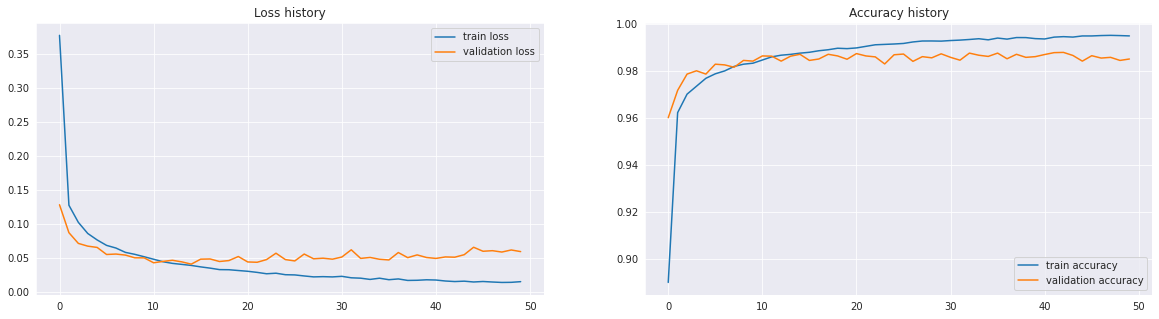

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

axs[0].plot(loss_history['train'], label='train loss')
axs[0].plot(loss_history['validation'], label='validation loss')
axs[0].set_title('Loss history')
axs[0].legend()

axs[1].plot(accuracy_history['train'], label='train accuracy')
axs[1].plot(accuracy_history['validation'], label='validation accuracy')
axs[1].set_title('Accuracy history')
axs[1].legend();

Сверточная нейронная сеть показывает ещё более лучший результат: во-первых, значение потперь на валидационном наборе в 2-3 раза ниже, чем на аналогичном, но в полносвязной сети; во-вторых, точность на валидации достигает 98,3%.